In [2]:
#载入包

import numpy as np
import pandas as pd
import os
from pandas import Series,DataFrame
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm
import math
import datetime
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
import sklearn.metrics as sklm
from sklearn.metrics import confusion_matrix
import sklearn.cluster as sklc
import seaborn as sn

%matplotlib inline

In [35]:
#数据清洗与整理

#input data
listings_data = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/listings.csv')
#drop columns and select points in Seattle
listings_data_1 = listings_data.drop(labels=['name','description','neighborhood_overview','host_thumbnail_url','host_picture_url','picture_url','calendar_last_scraped','host_url','host_name','host_about','scrape_id', 'last_scraped', 'source', 'listing_url', 'host_neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'calendar_updated', 'availability_60','availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review','calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'host_listings_count', 'host_total_listings_count'], axis=1)
listings_data_2 = listings_data_1.drop(listings_data_1[listings_data_1['has_availability'] == 'f'].index)
listings_seattle = listings_data_2.drop(listings_data_2[listings_data_2['neighbourhood'] != 'Seattle, Washington, United States'].index)
listings_seattle.reset_index(drop=True,inplace=True)

#NaN
listings_seattle['reviews_per_month'] = listings_seattle['reviews_per_month'].replace([np.nan],0)
listings_seattle['bathrooms_text'] = listings_seattle['bathrooms_text'].replace([np.nan],'0')
listings_seattle['bathrooms'] = listings_seattle['bathrooms_text'].str.split('\s+').str[0]
listings_seattle['bathrooms'] = listings_seattle['bathrooms'].replace('half-bath',0.5)
listings_seattle['bathrooms'] = listings_seattle['bathrooms'].replace('Half-bath',0.5)
listings_seattle['bathrooms'] = listings_seattle['bathrooms'].replace('Shared',0.5)
listings_seattle['bathrooms'] = listings_seattle['bathrooms'].replace([np.nan],0)
listings_seattle['bathrooms'] = listings_seattle['bathrooms'].astype(float)
listings_seattle['bedrooms'] = listings_seattle['bedrooms'].replace([np.nan],0)
listings_seattle['host_location'] = listings_seattle['host_location'].replace([np.nan],' ')
listings_seattle['host_response_time'] = listings_seattle['host_response_time'].replace([np.nan],'No response')
listings_seattle['host_response_rate'] = listings_seattle['host_response_rate'].replace([np.nan],'0')
listings_seattle['host_response_rate'] = listings_seattle['host_response_rate'].str.split('%').str[0]
listings_seattle['host_response_rate'] = listings_seattle['host_response_rate'].astype(int)
listings_seattle['host_acceptance_rate'] = listings_seattle['host_acceptance_rate'].replace([np.nan],'0')
listings_seattle['host_acceptance_rate'] = listings_seattle['host_acceptance_rate'].str.split('%').str[0]
listings_seattle['host_acceptance_rate'] = listings_seattle['host_acceptance_rate'].astype(float)
listings_seattle['price']=listings_seattle['price'].str.replace('$','')
listings_seattle['price']=listings_seattle['price'].str.replace(',','')
listings_seattle['price']=listings_seattle['price'].astype(float)
listings_seattle_1 = listings_seattle.drop(listings_data_1[listings_data_1['price'] == 0].index)
listings_seattle_1.reset_index(drop=True,inplace=True)
listings_seattle_1['license'] = listings_seattle_1['license'].str.contains('S',na = False)

#license改为t/f, license_tf, string格式
listings_seattle_1['license_tf'] = 0
for i in range(len(listings_seattle_1)):
    if listings_seattle_1['license'].iloc[i] == False:
        listings_seattle_1['license_tf'].iloc[i]='f'
    else:
        listings_seattle_1['license_tf'].iloc[i]='t'
        
#host_response_time文字改为5级，int格式
response_dic = {"No response":1,
               "a few days or more":2,
               "within a day":3,
               "within a few hours":4,
               "within an hour":5}
listings_seattle_1['response_time_num'] = 0
for i in range(len(listings_seattle_1)):
    listings_seattle_1['response_time_num'].iloc[i] = response_dic[listings_seattle_1['host_response_time'].iloc[i]]
#'No response'-1
#'a few days or more'-2
#'within a day'-3
#'within a few hours'-4
#'within an hour' -5

#host_verfications个数, host_verification_num, int格式
listings_seattle_1['host_verifications_num']=0
for i in range(len(listings_seattle_1)):
    listings_seattle_1['host_verifications_num'].iloc[i] = (listings_seattle_1['host_verifications'].iloc[i]).count(',')+1

#amenities个数, amenities_num, int格式
listings_seattle_1['amenities_num']=0
for i in range(len(listings_seattle_1)):
    listings_seattle_1['amenities_num'].iloc[i] = (listings_seattle_1['amenities'].iloc[i]).count(',')+1

#booked_30=30-availability_30
listings_seattle_1['book_30']=0
for i in range(len(listings_seattle_1)):
    listings_seattle_1['book_30'].iloc[i] = 30-listings_seattle_1['availability_30'].iloc[i]

#热门程度指数(popularity)：将月均评论数进行标准化作为过去热门程度，将未来一月已预定天数进行标准化作为预期热门程度，二者相加得到
#standardization公式,from lecture week6 P83
reviews_monthly_mean = listings_seattle_1['reviews_per_month'].mean()
reviews_monthly_mean = round (reviews_monthly_mean,2)
reviews_monthly_std = listings_seattle_1['reviews_per_month'].std()
reviews_monthly_std = round (reviews_monthly_std,2)
book30_mean = listings_seattle_1['book_30'].mean()
book30_mean = round(book30_mean,2)
book30_std = listings_seattle_1['book_30'].std()
book30_std = round(book30_std,2)
listings_seattle_1['pop_past'] = 0
listings_seattle_1['pop_future'] = 0
listings_seattle_1['popularity'] = 0
#过去热门程度，最后drop,范围[-0.96, 7.3]
for i in range(len(listings_seattle_1)):
    listings_seattle_1['pop_past'].iloc[i] = (listings_seattle_1['reviews_per_month'].iloc[i]-reviews_monthly_mean)/reviews_monthly_std
    listings_seattle_1['pop_past'].iloc[i] = round (listings_seattle_1['pop_past'].iloc[i],2)
#将来热门程度，最后drop,范围[-1.38, 1.45]
    listings_seattle_1['pop_future'].iloc[i] = (listings_seattle_1['book_30'].iloc[i]-book30_mean)/book30_std
    listings_seattle_1['pop_future'].iloc[i] = round (listings_seattle_1['pop_future'].iloc[i],2)
#热门程度指数(popularity), 范围[-2.34, 6.89]
    listings_seattle_1['popularity'].iloc[i] = listings_seattle_1['pop_past'].iloc[i] + listings_seattle_1['pop_future'].iloc[i] 

#经纬度计算两点间距离
def getDistance(latA, lonA, latB, lonB):
    ra = 6378140  # 赤道半径
    rb = 6356755  # 极半径
    flatten = (ra - rb) / ra  # Partial rate of the earth
    # change angle to radians
    radLatA = math.radians(latA)
    radLonA = math.radians(lonA)
    radLatB = math.radians(latB)
    radLonB = math.radians(lonB)
    pA = math.atan(rb / ra * math.tan(radLatA))
    pB = math.atan(rb / ra * math.tan(radLatB))
    x = math.acos(math.sin(pA) * math.sin(pB) + math.cos(pA) * math.cos(pB) * math.cos(radLonA - radLonB))
    # if math.cos(x / 2)==0:
    #     distance = 0
    # else:
    c1 = (math.sin(x) - x) * (math.sin(pA) + math.sin(pB)) ** 2 / math.cos(x / 2) ** 2
    c2 = (math.sin(x) + x) * (math.sin(pA) - math.sin(pB)) ** 2 / math.sin(x / 2) ** 2
    dr = flatten / 8 * (c1 - c2)
    distance = ra * (x + dr)
    distance = round(distance / 1000, 4)
    return distance

#每两个点之间计算距离
subset=listings_seattle_1.copy()
subset_xy0 = [[] for i in range(4224)]
for i in range(len(subset['longitude'])):
    for j in range(len(subset['longitude'])):
        if i==j:
            distance = 0
            subset_xy0[i].append(distance)
        elif (listings_seattle_1['latitude'].iloc[i]==listings_seattle_1['latitude'].iloc[j]) & (listings_seattle_1['longitude'].iloc[i]==listings_seattle_1['longitude'].iloc[j]):
            distance = 0
        else:
            distance = getDistance(subset['latitude'].iloc[i], subset['longitude'].iloc[i], subset['latitude'].iloc[j], subset['longitude'].iloc[j])
            subset_xy0[i].append(distance)    
for m in range(len(subset['longitude'])):
    subset_xy0[m] = pd.DataFrame(subset_xy0[m],columns=[m])
    subset = pd.concat([subset, subset_xy0[m]], axis=1)
subset

#筛选出距离小于等于0.5km的行，计算平均价格
columns_sub = pd.concat([subset.iloc[:,46:],listings_seattle_1['price'].head(n=4224)], axis=1)
columns_sub['relative_meanprice'] = 0 #这一个点对应的周边范围内平均价格
for i in range(4224):
    pricedf = columns_sub[columns_sub[i] <= 0.5].iloc[:, [i,4224]]
    columns_sub['relative_meanprice'].iloc[i] = pricedf['price'].mean()
#合并relative_meanprice到原数据集listings_seattle_1中
listings_seattle_1 = pd.concat([listings_seattle_1,columns_sub['relative_meanprice']],axis=1)

#与周边房源的相对价格：房源价格-周边2公里房源均价
listings_seattle_1['relative_price'] = 0
for i in range(len(listings_seattle_1['price'])):
    listings_seattle_1['relative_price'] = listings_seattle_1['price'] - listings_seattle_1['relative_meanprice']
listings_seattle_1

#room_type文字改为3级，int格式
type_dic = {"Shared room":1,
            "Private room":2,
            "Entire home/apt":3}
listings_seattle_1['type_num'] = 0
for i in range(len(listings_seattle_1)):
    listings_seattle_1['type_num'].iloc[i] = type_dic[listings_seattle_1['room_type'].iloc[i]]
#'Shared room'-1
#'Private room'-2
#'Entire home/apt'-3

#'host_location' -> 'host_location_tf' 判断房东是否为本地（tf）
listings_seattle_1['host_location_tf'] = 0
listings_seattle_1['host_location_tf'] = listings_seattle_1['host_location'].str.contains('Seattle',na = False)
for i in range(len(listings_seattle_1)):
    if listings_seattle_1['host_location_tf'].iloc[i] == False:
        listings_seattle_1['host_location_tf'].iloc[i]='f'
    else:
        listings_seattle_1['host_location_tf'].iloc[i] = 't'

#计算房东加入Airbnb的时间
listings_seattle_1['present_time'] = datetime.date.today()
listings_seattle_1['start_time'] = ''
listings_seattle_1['host_duration'] = ''
for i in range(len(listings_seattle_1)):
    listings_seattle_1['start_time'].iloc[i] = datetime.datetime.strptime(str(listings_seattle_1['host_since'].iloc[i]), '%Y-%m-%d').date()
    listings_seattle_1['host_duration'].iloc[i] = (listings_seattle_1['present_time'].iloc[i] - listings_seattle_1['start_time'].iloc[i]).days

#删除无效变量
listings_seattle_final = listings_seattle_1
listings_seattle_clean = listings_seattle_1.drop(labels=['host_since','host_location','host_response_time','host_verifications','neighbourhood','latitude','longitude','bathrooms_text','amenities','has_availability','license','present_time','start_time','property_type','room_type','availability_30','book_30','reviews_per_month'], axis=1)

#output csv
listings_seattle_final.to_csv('listings_final.csv',index=False,header=True)
listings_seattle_clean.to_csv('listings_clean.csv',index=False,header=True)

C:\Users\xianl\AppData\Local\Temp\ipykernel_10628\3646416889.py:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  listings_seattle['price']=listings_seattle['price'].str.replace('$','')
C:\Users\xianl\AppData\Local\Temp\ipykernel_10628\3646416889.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_seattle_1['license_tf'].iloc[i]='t'
C:\Users\xianl\AppData\Local\Temp\ipykernel_10628\3646416889.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_

[1 0 1 ... 0 0 0]
For n_clusters = 3 The average silhouette_score is : 0.5872436612109869
For n_clusters = 4 The average silhouette_score is : 0.5054633267229403
For n_clusters = 5 The average silhouette_score is : 0.42701521315857344


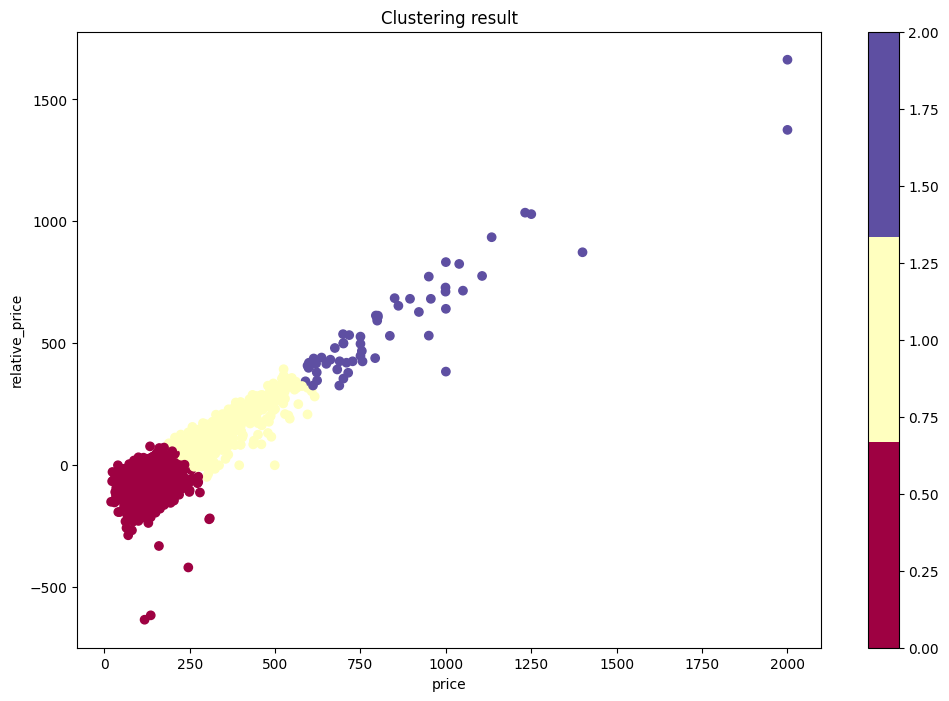

In [36]:
#价格聚类分析（划分为3档）

#read in data
seattle = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/listings_clean.csv')

#when num_cluster=3, silhouette score is the highest
seattle_sub = seattle.loc[:,['price','relative_price']]
seattle_sub.columns = ['price', 'relative_price']
num_clusters = 3
random_state_seed = 100
kmeans_output = sklc.KMeans(n_clusters = num_clusters, random_state = random_state_seed).fit(seattle_sub)
clustering_ids_kmeans = kmeans_output.labels_
print(clustering_ids_kmeans) #check the clustering results
seattle_sub = seattle_sub.assign(cluster_id = clustering_ids_kmeans) #assign clustering id with the original data

#plot the result of clustering
fig, ax = plt.subplots(figsize = (12,8))
# number of clusters
n_clusters = seattle_sub.cluster_id.nunique() #cluster_id.nunique() return number of unique elements in the object
# get discrete colormap
cmap = plt.get_cmap('Spectral',n_clusters)
# scatter points
scatter = ax.scatter(seattle_sub.price, seattle_sub.relative_price, c = seattle_sub.cluster_id, cmap = cmap)
ax.set_xlabel('price')
ax.set_ylabel('relative_price')
ax.set_title('Clustering result')
# add colorbar
cbar = plt.colorbar(scatter)

#calculate the silhouette_score when num_cluster=3,4,5
silhouette_kmeans = sklm.silhouette_score(seattle_sub,clustering_ids_kmeans) #(data points,labels of clusters)
df_silhouette_score = pd.DataFrame({'n_cluster':[3,4,5], 'silhouette_score':[0,0,0]})
for index, row in df_silhouette_score.iterrows():
    n_clusters = row['n_cluster']
    clusterer = sklc.KMeans(n_clusters = n_clusters, random_state = random_state_seed).fit(seattle_sub)
    cluster_labels = clusterer.labels_
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = sklm.silhouette_score(seattle_sub, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    row['silhouette_score'] = silhouette_avg

#合并结果
class_price = pd.concat([seattle, seattle_sub.iloc[:,2]], axis = 1)
# 2-highest price
# 1-medium price
# 0-lowest price

#导出
class_price.to_csv('class_price.csv',index = False,header = True)

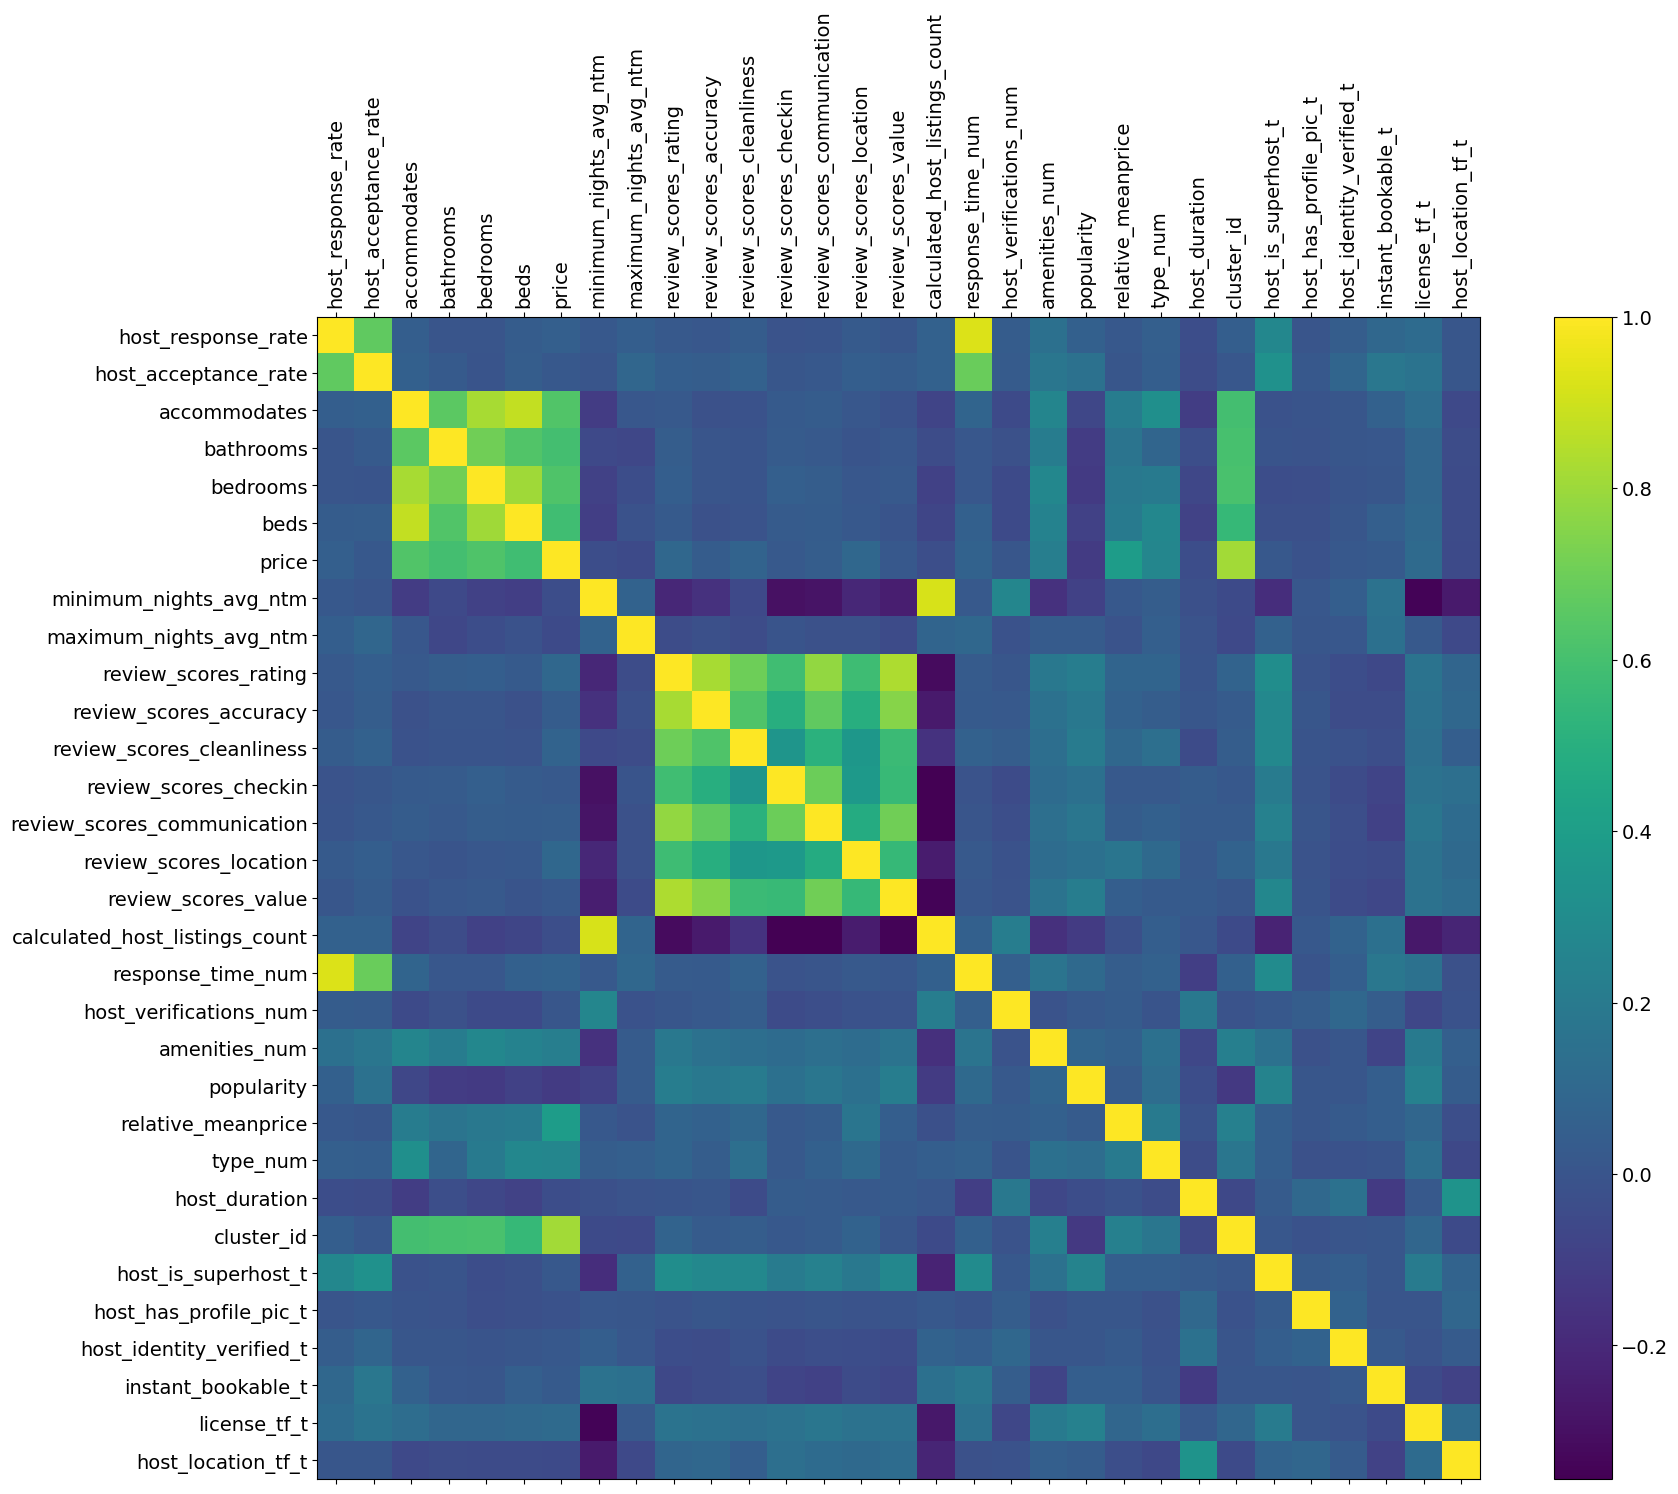

In [37]:
#VIF与相关性检验

#data preparation
seattle_raw = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/class_price.csv')
seattle_dum = pd.get_dummies(seattle_raw)
seattle = seattle_dum.drop(labels=['id','host_id','pop_past','pop_future','relative_price','host_is_superhost_f','host_has_profile_pic_f','host_identity_verified_f','instant_bookable_f','license_tf_f','host_location_tf_f'], axis=1)

#def VIF
def drop_column_using_vif_(df, thresh=5):
    while True:
        df_with_const = add_constant(df)
        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()
        vif_df = vif_df.drop('const')
        if vif_df.VIF.max() > thresh:
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            break
    return df

#VIF
'''
seattle = seattle.dropna(axis=0, how = 'any')
seattle_VIF = drop_column_using_vif_(seattle)
print(seattle_VIF.columns)
'''

#correlation
plt.rcParams['axes.grid'] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(seattle_VIF.corr(), fignum=f.number)
plt.xticks(range(seattle_VIF.shape[1]), seattle_VIF.columns, fontsize=14, rotation=90)
plt.yticks(range(seattle_VIF.shape[1]), seattle_VIF.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

#暂时排除VIF
seattle_VIF = seattle.dropna(axis=0, how = 'any')

In [38]:
#OLS_price

seattle_VIF_all = seattle_VIF.drop(labels=['cluster_id'], axis=1)
VIF_price = seattle_VIF_all.drop(labels=['price'], axis=1)
OLS_price = sm.OLS(endog = seattle_VIF_all[['price']], exog = sm.add_constant(VIF_price)).fit()
OLS_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     159.0
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:33:51   Log-Likelihood:                -21394.
No. Observations:                3653   AIC:                         4.285e+04
Df Residuals:                    3623   BIC:                         4.303e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           -331.9569     48.305     -6.872      0.000    -426.664    -237.249
host_response_rate                -0.0545      0.136     -0.402      0.688      -0.321       0.212
host_acceptance_rate              -0.3420      0.080     -4.288      0.000      -0.498      -0.186
accommodates                      11.7175      1.374      8.530      0.000       9.024      14.411
bathrooms                         51.3757      3.275     15.686      0.000      44.954      57.797
bedrooms                          22.3435      2.659      8.404      0.000      17.131      27.556
beds                              -1.7781      2.061     -0.863      0.388      -5.818       2.262
minimum_nights_avg_ntm            -0.0670      0.043     -1.547      0.122      -0.152       0.018
maximum_nights_avg_ntm            -0.0092      0.003     -2.947      0.003      -0.015      -0.003
review_scores_rating              55.7656     11.979      4.655      0.000      32.280      79.251
review_scores_accuracy            -8.2714      9.550     -0.866      0.386     -26.994      10.452
review_scores_cleanliness         13.9865      7.256      1.928      0.054      -0.240      28.213
review_scores_checkin            -11.2649      7.845     -1.436      0.151     -26.646       4.116
review_scores_communication      -12.6126      8.927     -1.413      0.158     -30.115       4.889
review_scores_location            26.8982      8.148      3.301      0.001      10.924      42.873
review_scores_value              -35.0085      8.327     -4.204      0.000     -51.335     -18.682
calculated_host_listings_count     0.1630      0.077      2.117      0.034       0.012       0.314
response_time_num                  8.6485      3.481      2.485      0.013       1.824      15.473
host_verifications_num             4.7970      3.461      1.386      0.166      -1.989      11.583
amenities_num                      0.3622      0.120      3.025      0.003       0.127       0.597
popularity                        -8.1936      1.148     -7.134      0.000     -10.445      -5.942
relative_meanprice                 0.6043      0.030     20.334      0.000       0.546       0.663
type_num                          28.9375      4.398      6.580      0.000      20.315      37.561
host_duration                      0.0030      0.002      1.931      0.054   -4.49e-05       0.006
host_is_superhost_t                3.5640      3.315      1.075      0.282      -2.936      10.064
host_has_profile_pic_t            -1.4958     18.825     -0.079      0.937     -38.404      35.412
host_identity_verified_t           1.3856      4.417      0.314      0.754      -7.274      10.045
instant_bookable_t                 3.4563      3.122      1.107      0.268      -2.665       9.578
license_tf_t  

In [39]:
#Kolmogorov-Smirnov test
#sn.displot(a = seattle_VIF['price'], bins = 10, fit = stats.norm, norm_hist = True,
from statsmodels.stats.diagnostic import lilliefors
lilliefors(seattle_VIF_all['price'])

(0.157314035054529, 0.0009999999999998899)

In [40]:
#OLS_price_high

seattle_VIF2 = seattle_VIF.drop(seattle_VIF[seattle_VIF['cluster_id'] != 2].index)
VIF_price = seattle_VIF2.drop(labels=['price'], axis=1)
OLS_price = sm.OLS(endog = seattle_VIF2[['price']], exog = sm.add_constant(VIF_price)).fit()
OLS_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     1.864
Date:                Wed, 07 Dec 2022   Prob (F-statistic):             0.0656
Time:                        00:33:57   Log-Likelihood:                -336.34
No. Observations:                  52   AIC:                             730.7
Df Residuals:                      23   BIC:                             787.3
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
host_response_rate                -7.4686      5.157     -1.448      0.161     -18.137       3.200
host_acceptance_rate              -1.9798      3.417     -0.579      0.568      -9.048       5.088
accommodates                      66.2945     32.285      2.053      0.052      -0.492     133.080
bathrooms                         -1.2232     71.534     -0.017      0.987    -149.203     146.757
bedrooms                          59.4248     77.168      0.770      0.449    -100.209     219.059
beds                             -95.2500     38.702     -2.461      0.022    -175.310     -15.189
minimum_nights_avg_ntm            -6.1469      8.343     -0.737      0.469     -23.406      11.113
maximum_nights_avg_ntm            -0.2143      0.104     -2.054      0.052      -0.430       0.002
review_scores_rating             735.4304    680.932      1.080      0.291    -673.186    2144.046
review_scores_accuracy           126.1919    258.402      0.488      0.630    -408.354     660.737
review_scores_cleanliness       -117.8185    138.428     -0.851      0.403    -404.178     168.541
review_scores_checkin           -501.2667    944.080     -0.531      0.601   -2454.245    1451.712
review_scores_communication       62.7649   1092.724      0.057      0.955   -2197.708    2323.237
review_scores_location          -448.6041    622.357     -0.721      0.478   -1736.048     838.839
review_scores_value             -179.9638    386.771     -0.465      0.646    -980.060     620.132
calculated_host_listings_count     5.1358      4.621      1.111      0.278      -4.423      14.694
response_time_num                129.0238    105.079      1.228      0.232     -88.349     346.397
host_verifications_num           -43.8170    120.844     -0.363      0.720    -293.801     206.167
amenities_num                     -2.6838      3.665     -0.732      0.471     -10.266       4.899
popularity                         4.6360     38.716      0.120      0.906     -75.454      84.726
relative_meanprice                 1.7638      0.610      2.890      0.008       0.501       3.026
type_num                        -162.4667    215.498     -0.754      0.459    -608.259     283.325
host_duration                      0.0574      0.059      0.980      0.337      -0.064       0.179
cluster_id                      1055.5086   1540.021      0.685      0.500   -2130.267    4241.285
host_is_superhost_t              -53.4489     97.515     -0.548      0.589    -255.175     148.277
host_has_profile_pic_t           527.7543    770.010      0.685      0.500   -1065.134    2120.642
host_identity_verified_t          36.9974    139.962      0.264      0.794    -252.537     326.531
instant_bookable_t               -50.5336    110.571     -0.457      0.652    -279.266     178.199
license_tf_t  

In [41]:
#OLS_price_medium

seattle_VIF1 = seattle_VIF.drop(seattle_VIF[seattle_VIF['cluster_id'] != 1].index)
VIF_price = seattle_VIF1.drop(labels=['price'], axis=1)
OLS_price = sm.OLS(endog = seattle_VIF1[['price']], exog = sm.add_constant(VIF_price)).fit()
OLS_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     21.12
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           1.52e-79
Time:                        00:34:01   Log-Likelihood:                -4641.0
No. Observations:                 832   AIC:                             9342.
Df Residuals:                     802   BIC:                             9484.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
host_response_rate                -0.2546      0.244     -1.044      0.297      -0.733       0.224
host_acceptance_rate              -0.3046      0.144     -2.120      0.034      -0.587      -0.023
accommodates                       7.4450      1.723      4.321      0.000       4.063      10.827
bathrooms                         21.9552      4.102      5.352      0.000      13.903      30.007
bedrooms                          15.0865      4.116      3.666      0.000       7.008      23.165
beds                              -4.6085      2.546     -1.810      0.071      -9.606       0.389
minimum_nights_avg_ntm             0.4490      0.106      4.245      0.000       0.241       0.657
maximum_nights_avg_ntm            -0.0161      0.004     -3.736      0.000      -0.025      -0.008
review_scores_rating              32.4612     22.835      1.422      0.156     -12.362      77.284
review_scores_accuracy           -33.2160     18.559     -1.790      0.074     -69.646       3.214
review_scores_cleanliness         13.8551     14.708      0.942      0.346     -15.016      42.726
review_scores_checkin             -4.7297     14.056     -0.336      0.737     -32.321      22.862
review_scores_communication       -1.3395     17.000     -0.079      0.937     -34.709      32.030
review_scores_location            50.0635     15.751      3.178      0.002      19.146      80.981
review_scores_value              -35.2511     14.055     -2.508      0.012     -62.840      -7.662
calculated_host_listings_count    -0.8336      0.196     -4.260      0.000      -1.218      -0.449
response_time_num                  7.6311      6.477      1.178      0.239      -5.082      20.344
host_verifications_num            -0.1021      5.488     -0.019      0.985     -10.874      10.670
amenities_num                      0.5438      0.189      2.873      0.004       0.172       0.915
popularity                        -5.0033      1.918     -2.608      0.009      -8.769      -1.238
relative_meanprice                 0.6999      0.052     13.484      0.000       0.598       0.802
type_num                         -27.5026     15.128     -1.818      0.069     -57.198       2.193
host_duration                      0.0045      0.002      1.941      0.053   -5.14e-05       0.009
cluster_id                        53.0871     90.558      0.586      0.558    -124.672     230.846
host_is_superhost_t               13.3572      5.415      2.467      0.014       2.729      23.986
host_has_profile_pic_t           -31.5271     25.369     -1.243      0.214     -81.325      18.271
host_identity_verified_t           2.7753      7.331      0.379      0.705     -11.615      17.166
instant_bookable_t                -0.7976      5.105     -0.156      0.876     -10.818       9.223
license_tf_t  

In [42]:
#OLS_price_low

seattle_VIF0 = seattle_VIF.drop(seattle_VIF[seattle_VIF['cluster_id'] != 0].index)
VIF_price = seattle_VIF0.drop(labels=['price'], axis=1)
OLS_price = sm.OLS(endog = seattle_VIF0[['price']], exog = sm.add_constant(VIF_price)).fit()
OLS_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     85.83
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:34:04   Log-Likelihood:                -13564.
No. Observations:                2769   AIC:                         2.719e+04
Df Residuals:                    2739   BIC:                         2.737e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           -158.9143     21.504     -7.390      0.000    -201.080    -116.749
host_response_rate                -0.0943      0.059     -1.611      0.107      -0.209       0.020
host_acceptance_rate               0.0232      0.035      0.670      0.503      -0.045       0.091
accommodates                       6.1946      0.727      8.518      0.000       4.769       7.621
bathrooms                          7.7361      1.881      4.112      0.000       4.047      11.425
bedrooms                           7.1126      1.234      5.765      0.000       4.693       9.532
beds                               0.1349      1.135      0.119      0.905      -2.091       2.361
minimum_nights_avg_ntm            -0.0588      0.018     -3.227      0.001      -0.095      -0.023
maximum_nights_avg_ntm         -1.429e-05      0.001     -0.010      0.992      -0.003       0.003
review_scores_rating              12.3645      5.259      2.351      0.019       2.053      22.676
review_scores_accuracy            -4.1209      4.106     -1.004      0.316     -12.172       3.930
review_scores_cleanliness         17.0949      3.275      5.220      0.000      10.673      23.517
review_scores_checkin             -9.5854      3.430     -2.795      0.005     -16.310      -2.861
review_scores_communication       -1.7817      3.812     -0.467      0.640      -9.257       5.694
review_scores_location            11.6328      3.480      3.343      0.001       4.809      18.456
review_scores_value              -10.2600      3.676     -2.791      0.005     -17.467      -3.053
calculated_host_listings_count     0.1409      0.032      4.362      0.000       0.078       0.204
response_time_num                  3.7420      1.498      2.498      0.013       0.805       6.679
host_verifications_num             4.4636      1.553      2.875      0.004       1.419       7.508
amenities_num                      0.3092      0.055      5.613      0.000       0.201       0.417
popularity                        -2.0974      0.508     -4.128      0.000      -3.094      -1.101
relative_meanprice                 0.2384      0.013     17.802      0.000       0.212       0.265
type_num                          33.0346      1.818     18.171      0.000      29.470      36.599
host_duration                      0.0004      0.001      0.556      0.578      -0.001       0.002
cluster_id                     -5.937e-13   2.12e-13     -2.796      0.005   -1.01e-12   -1.77e-13
host_is_superhost_t                2.0397      1.474      1.384      0.166      -0.850       4.929
host_has_profile_pic_t             6.5417      8.872      0.737      0.461     -10.854      23.938
host_identity_verified_t           1.7632      1.949      0.905      0.366      -2.057       5.584
instant_bookab